# West Nile Virus Prediction

kaggle link: https://www.kaggle.com/c/predict-west-nile-virus

In [2]:
import pandas as pd
import numpy as np

In [127]:
X_train_df = pd.read_csv('../input/train.csv')

X_test_df = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sampleSubmission.csv')
weather = pd.read_csv('../input/weather.csv')



In [128]:
#have not taken this into account yet

#spraying is a strong predictor of reduction of the virus, so put this as a feature ' distance to spray' 
spray = pd.read_csv('../input/spray.csv')
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [129]:
X_train_df.head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


all information that is contained in adress variables is also containder in latitude and longitiude (mosq have no conception of address) => drop all things relating to address. 

In [130]:
weather.head(1)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2


CodeSum gives a significant weather types, ex  HAZE, SMOKE, etc. if NaN, then moderate

M = Missing Data, or data that are not normally reported for the station.

Weather contains a lot of information. I think that decision trees won't work well with that many different columns. First I will just let it be,
and then i'll try to condense the information.

In [131]:
weather.Station.unique()

array([1, 2])

In [132]:
There exists two different stations that collects data. one way to to aggregate their data is to take their average. I'll start by letting station 1 represent all.

SyntaxError: invalid syntax (<ipython-input-132-e496c628b990>, line 1)

In [133]:
weather = weather[weather.Station == 1]
#Water 1 is missing so drop it 
weather = weather.drop('Water1', axis=1)

#give nominal number names to the CodeSum variable
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
lbl.fit(weather.CodeSum)
weather.CodeSum = lbl.transform(weather.CodeSum)

In [134]:
X_train_df['NumMosquitos'].unique()
#no 0'oes....wonder what can be the significance of this variable

array([ 1,  4,  2,  3,  5,  9,  7, 10,  8,  6, 19, 20, 25, 16, 11, 12, 28,
       18, 50, 35, 14, 22, 21, 37, 27, 13, 39, 29, 15, 17, 34, 26, 32, 47,
       44, 23, 46, 48, 42, 33, 45, 24, 41, 38, 40, 36, 43, 49, 30, 31])

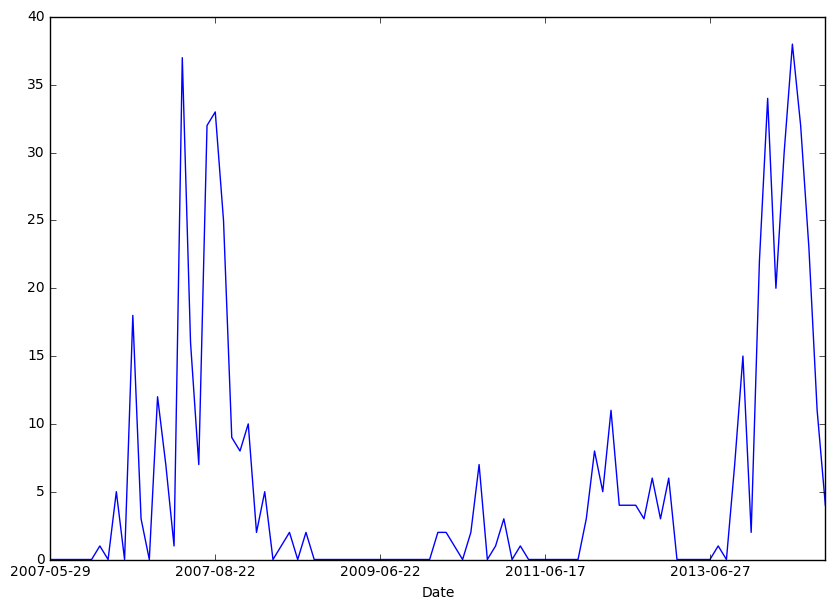

In [135]:
#some data exploration
import matplotlib.pyplot as plt
X_train_df.groupby(['Date'])['WnvPresent'].sum().plot(figsize=(10,7))
plt.show()
#there does not seem to be a time trend in the data. however maybe per month? (summer months example)

In [136]:
len(X_train_df[X_train_df['WnvPresent']==1]) / len(X_train_df)
#pretty skewed data!

0.05244622120692937

In [137]:
X_test_df.head(1)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [138]:
X_train_df = pd.merge(X_train_df, weather, on=['Date'], how='inner')
X_test_df = pd.merge(X_test_df, weather, on=['Date'], how='inner')

def create_year(x):
    return x.split("-")[0]

def create_month(x):
    return x.split('-')[1]

def create_day(x):
    return x.split('-')[2]

X_train_df['year'] = X_train_df.Date.apply(create_year)
X_train_df['month'] =  X_train_df.Date.apply(create_month)
X_train_df['day'] =  X_train_df.Date.apply(create_day)

X_test_df['year'] = X_test_df.Date.apply(create_year)
X_test_df['month'] =  X_test_df.Date.apply(create_month)
X_test_df['day'] =  X_test_df.Date.apply(create_day)




In [139]:
#shuffle the data set so I can split it up to train and cv
X_train_df = X_train_df.sample(frac=1)

Y_train_df = X_train_df[['WnvPresent']]

X_train_df = X_train_df[['year', 'month', 'day', 'Species', 'Latitude', 'Longitude' ] ]
X_test_df = X_test_df[['year', 'month', 'day', 'Species', 'Latitude', 'Longitude' ] ]
#so i'm removing date and having month an day there instead: 

In [142]:
#cast lat and long to int
# encode species 
X_train_df.Latitude = X_train_df.Latitude.apply(lambda lat: int(lat))
X_train_df.Longitude = X_train_df.Longitude.apply(lambda long: int(long))

X_test_df.Latitude = X_test_df.Latitude.apply(lambda lat: int(lat))
X_test_df.Longitude = X_test_df.Longitude.apply(lambda long: int(long))

lbl = preprocessing.LabelEncoder()
lbl.fit(X_train_df.Species)
X_train_df.Species = lbl.transform(X_train_df.Species)

lbl = preprocessing.LabelEncoder()
lbl.fit(X_test_df.Species)
X_test_df.Species = lbl.transform(X_test_df.Species)



In [144]:
from sklearn.ensemble import RandomForestClassifier

#randomforest will use bootstrap by default
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train_df.values, Y_train_df.values)

/Users/gk/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

(10506, 1)

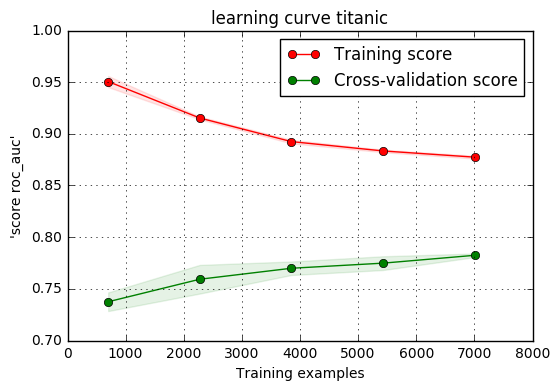

In [150]:
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve

#this function is taken from sk-learn

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("'score roc_auc'")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


plot_learning_curve(RandomForestClassifier(n_estimators=1000), "learning curve titanic", X_train_df.values, Y_train_df.values.reshape(10506,), ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
#this took a long time. the Y values need to come in in shape form (something, ) and not (something, 1)
plt.show()

In [ ]:
Looks promising!



In [159]:
#my benchmark submission
X_test_df['Prediction'] = clf.predict(X_test_df.values)

X_test_df.index=range(1, len(X_test_df) + 1)

X_test_df['Prediction'].to_csv('../working/SampleSubmission.csv', index_label=['Id'] ,header=['WnvPresent'])

X_test_df = X_test_df[['year', 'month', 'day', 'Species', 'Latitude', 'Longitude']]


In [33]:


# data_length = len(X_train_df)
# train_length = round(data_length * 0.8)

# X_cv_df = X_train_df[train_length:]
# Y_cv_df = Y_train_df[train_length:]

# X_train_df = X_train_df[0:train_length]
# Y_train_df = Y_train_df[0:train_length]


###  Questions and thoughts

how to handle time series? if there is a trend in in it / no trend

signifcance of trap variable

what workflow to use, when it comes to reusability, from other notebooks?



In [153]:
len(X_test_df)

116293